<a href="https://colab.research.google.com/github/SamarpitaBDas/character_design_ai/blob/main/character_sheet_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install --upgrade diffusers transformers -q

In [18]:
from pathlib import Path
import tqdm
import torch
import pandas as pd
import numpy as np
from diffusers import StableDiffusionPipeline
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [19]:
class CFG:
    device = "cuda"
    seed = 42
    generator = torch.Generator(device).manual_seed(seed)
    image_gen_steps = 35
    image_gen_model_id = "stabilityai/stable-diffusion-2"
    image_gen_size = (400,400)
    image_gen_guidance_scale = 9
    prompt_gen_model_id = "gpt2"
    prompt_dataset_size = 6
    prompt_max_length = 12

In [20]:
image_gen_model = StableDiffusionPipeline.from_pretrained(
    CFG.image_gen_model_id,
    torch_dtype=torch.float16,
    revision="fp16",
    guidance_scale=CFG.image_gen_guidance_scale
)

image_gen_model = image_gen_model.to(CFG.device)

Keyword arguments {'guidance_scale': 9} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/d75b612d366d802b1753960de862a9270c8d55f1/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [21]:
from google_drive_downloader import GoogleDriveDownloader as gdd
from PIL import Image

In [22]:
from google_drive_downloader import GoogleDriveDownloader as gdd
from PIL import Image

def generate_character_image(image_url, prompt, model):
    # Step 1: Download the image from Google Drive
    gdd.download_file_from_google_drive(file_id=image_url, dest_path='input_image.png')

    # Step 2: Load the image
    input_image = Image.open('input_image.png')

    # Step 3: Process the prompt and modify the image as needed
    modified_image = process_image_with_prompt(input_image, prompt)

    # Step 4: Generate final image based on the modified image and prompt
    final_image = generate_final_image(modified_image, prompt, model)

    return final_image

def process_image_with_prompt(image, prompt):
    # Implement logic to modify the image based on the prompt
    # For example, changing gender or clothing style
    return modified_image  # Return the modified image

def generate_final_image(base_image, prompt, model):
    # Use the prompt to generate a final image based on the modified image
    generated_image = model(
        f"Character based on {prompt}",  # Adjust prompt as needed
        num_inference_steps=CFG.image_gen_steps,
        generator=CFG.generator,
        guidance_scale=CFG.image_gen_guidance_scale
    ).images[0]

    return generated_image


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['show liora casting a healing spell with a gentle smile . 7 . back view : display her staff glowing and her robe flowing . 8 . side view : highlight her calm demeanor and delicate features 9 . items : healing potions , spellbook . 1 0 . background : a serene temple with soft light .']


  0%|          | 0/35 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['show liora casting a healing spell with a gentle smile . 7 . back view : display her staff glowing and her robe flowing . 8 . side view : highlight her calm demeanor and delicate features 9 . items : healing potions , spellbook . 1 0 . background : a serene temple with soft light .']


  0%|          | 0/35 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['show liora casting a healing spell with a gentle smile . 7 . back view : display her staff glowing and her robe flowing . 8 . side view : highlight her calm demeanor and delicate features 9 . items : healing potions , spellbook . 1 0 . background : a serene temple with soft light .']


  0%|          | 0/35 [00:00<?, ?it/s]

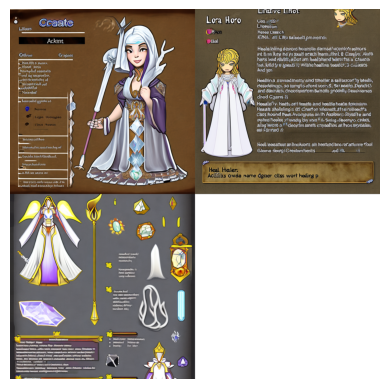

In [24]:
prompt_description = "Create a game character sheet for a character named Liora. Include the following sections:  1. Name: Liora 2. Class: Healer 3. Description: A kind-hearted mage with flowing white robes and a staff adorned with crystals. 4. Abilities: Heal, Revive, Barrier 5. Accessories: Crystal Staff, Healing Potion 6. Front view: Show Liora casting a healing spell with a gentle smile. 7. Back view: Display her staff glowing and her robe flowing.  8. Side view: Highlight her calm demeanor and delicate features 9. Items: Healing potions, spellbook. 10. Background: A serene temple with soft light."
character_sheet_image = generate_image(prompt_description, image_gen_model)

# Display the generated character sheet
plt.imshow(character_sheet_image)
plt.axis('off')
plt.show()

  0%|          | 0/35 [00:00<?, ?it/s]

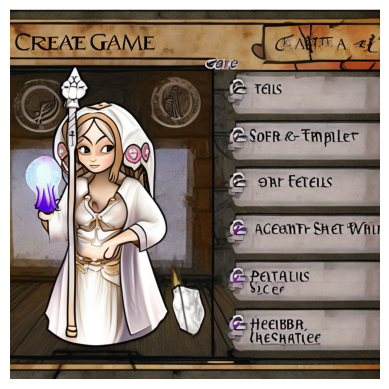

In [25]:
import matplotlib.pyplot as plt

def generate_character_sheet_from_prompt(prompt, model):
    # Combine the prompt details into a cohesive description for the image
    combined_prompt = (
        "Create a game character sheet for a character named Liora. "
        "She is a kind-hearted mage in flowing white robes, casting a healing spell with a gentle smile. "
        "Her staff adorned with crystals is glowing, and the background features a serene temple with soft light. "
        "Include her accessories like healing potions and a spellbook."
    )

    # Generate the final character sheet image
    character_sheet_image = model(
        combined_prompt,
        num_inference_steps=CFG.image_gen_steps,
        generator=CFG.generator,
        guidance_scale=CFG.image_gen_guidance_scale
    ).images[0]

    return character_sheet_image

# Example usage
prompt_description = "Create a game character sheet for a character named Liora. Include the following sections: 1. Name: Liora 2. Class: Healer 3. Description: A kind-hearted mage with flowing white robes and a staff adorned with crystals. 4. Abilities: Heal, Revive, Barrier 5. Accessories: Crystal Staff, Healing Potion 6. Front view: Show Liora casting a healing spell with a gentle smile. 7. Back view: Display her staff glowing and her robe flowing. 8. Side view: Highlight her calm demeanor and delicate features 9. Items: Healing potions, spellbook. 10. Background: A serene temple with soft light."

character_sheet_image = generate_character_sheet_from_prompt(prompt_description, image_gen_model)

# Display the generated character sheet
plt.imshow(character_sheet_image)
plt.axis('off')
plt.show()


  0%|          | 0/35 [00:00<?, ?it/s]

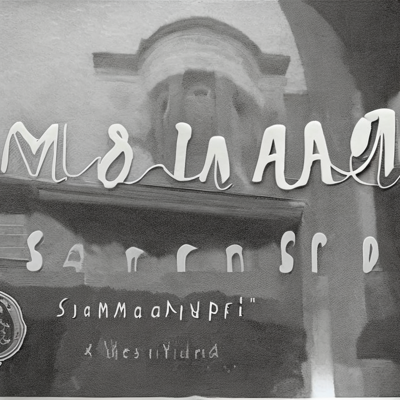

In [ ]:
generate_image("Samarpita",image_gen_model)